
# Preparations

In [1]:
import Pkg
Pkg.DEFAULT_IO[] = stdout;

### Fetch Function Files

In [27]:
include("../../Codebase/Functions/plotting_functions.jl");
include("../../Codebase/Functions/file_managment_functions.jl");
include("../Functions/data_handling_functions.jl");
include("../Functions/behaviour_plotting_functions.jl");

In [28]:
# For a parameter set, returns the 4 paraemters τ, v0, n, η.
function get_τ_v0_n_η(parameters)
    (length(parameters)==4) && return parameters
    (length(parameters)==6) && return parameters[3:6]
    error("Paraemter entry set have weird length (nether 4 nor 6).")
end

get_τ_v0_n_η (generic function with 1 method)

### Fetches Packages

In [3]:
using Revise, ForwardDiff, Parameters, Setfield, Plots, LinearAlgebra
using DifferentialEquations
using BifurcationKit
using Statistics
const BK = BifurcationKit

# sup norm
norminf(x) = norm(x, Inf);

### Declares the model

In [4]:
function genSigModel!(dz, z, p, t)
    S, D, τ, v0, n, η = p
    σ,A1,A2,A3 = z

    dz[1] = v0 + ((S*σ)^n)/((S*σ)^n + (D*A3)^n + 1) - σ
    dz[2] = (σ-A1)/τ
    dz[3] = (A1-A2)/τ
    dz[4] = (A2-A3)/τ
    dz
end
genSigModel = (z, p) -> genSigModel!(similar(z), z, p, 0);

### Plotting Functions

In [5]:
select_bps(cont,idxs) = map(idx -> cont.specialpoint[idx], idxs);
function split_branch(branch,starts,ends)
    return map(i -> branch.branch[starts[i]:ends[i]], 1:length(starts))
end
function plot_bp!(bp,idx,color;kwargs...)
    scatter!((bp.branch[idx].param,bp.branch[idx].x);color=color,label="",kwargs...)
end
function plot_bp_po!(bp,idx,color;kwargs...)
    scatter!((bp.branch[idx].param,bp.branch[idx].max);color=color,label="",kwargs...)
    scatter!((bp.branch[idx].param,bp.branch[idx].min);color=color,label="",kwargs...)
end
function plot_po!(branch;kwargs...)
    plot!(getfield.(branch,:param),getfield.(branch,:min); label="", kwargs...)
    plot!(getfield.(branch,:param),getfield.(branch,:max); label="", kwargs...)
end
function plot_branch!(branch;cS=:blue,cU=:red,kwargs...)
    stab = mean(getfield.(branch,:stable))>0.5
    plot!(getfield.(branch,:param),getfield.(branch,:x); label="", kwargs...)
end;

In [6]:
function make_po_args(pars)
    return (recordFromSolution = (x, p) -> begin
        xtt = BK.getPeriodicOrbit(p.prob, x, @set pars.S = p.p)
        return (max = maximum(xtt[1,:]),
                min = minimum(xtt[1,:]),
                period = getPeriod(p.prob, x, @set pars.S = p.p))
    end,
    plotSolution = (x, p; k...) -> begin
            xtt = BK.getPeriodicOrbit(p.prob, x, @set pars.S = p.p)
            plot!(xtt.t, xtt.u[1,:]; label = "X", k...)
            plot!(br; subplot = 1, putspecialptlegend = false)
        end,
    normC = norminf);
end;

### Plot settings

In [7]:
gr(); 
mm = Plots.mm
default(fmt = :png,framestyle=:box,grid=false,xguidefontsize=16,yguidefontsize=16,titlefontsize=18);

In [8]:
vert_line_h = 1.25
red_scale_4 = [RGB{Float64}(1.0,0.6,0.6),RGB{Float64}(1.0,0.4,0.4),RGB{Float64}(1.0,0.2,0.2),RGB{Float64}(0.66,0.,0.),RGB{Float64}(0.33,0.,0.)];
green_blue_scale_4 = [RGB{Float64}(0.,1.,0.0),RGB{Float64}(0.,0.66,0.33),RGB{Float64}(0.,0.33,0.66),RGB{Float64}(0.4,0.4,1.)];
blue_scale_3 = [RGB{Float64}(0.,0.7,0.7) RGB{Float64}(0.,.0,1.) RGB{Float64}(0.7,0.0,0.7)];

# Analysis

## Initial set of bifurcation diagrams

### Prepare options

In [11]:
ms = 8
lw = 8 
la = 0.9;

In [12]:
# Bifurcation diagram 1.
p_vals1 = [1.,0.25,10.0,0.1,3,0.];
par1 = (S=p_vals1[1],D=p_vals1[2],τ=p_vals1[3],v0=p_vals1[4],n=p_vals1[5],η=p_vals1[6]);
S_span1 = (1.,4.); S_vals1 = [1.25,1.75,2.25,3.];

# Bifurcation diagram 2.
p_vals2 = [1.,2.8,20.0,0.1,3,0.]; 
par2 = (S=p_vals2[1],D=p_vals2[2],τ=p_vals2[3],v0=p_vals2[4],n=p_vals2[5],η=p_vals2[6]);
S_span2 = (1.,5.); S_vals2 = [1.75,2.5,3,3.85];

# Bifurcation diagram 3.
p_vals3 = [1.,5.,10.0,0.1,3,0.]; 
par3 = (S=p_vals3[1],D=p_vals3[2],τ=p_vals3[3],v0=p_vals3[4],n=p_vals3[5],η=p_vals3[6]);
S_span3 = (1.,10.); S_vals3 = [2,3.5,5,8];

In [13]:
bpProb1 = BifurcationProblem(genSigModel, fill(par1.v0,4), par1, (@lens _.S); recordFromSolution = (x, p) -> x[1]);
bpProb2 = BifurcationProblem(genSigModel, fill(par2.v0,4), par2, (@lens _.S); recordFromSolution = (x, p) -> x[1]);
bpProb3 = BifurcationProblem(genSigModel, fill(par3.v0,4), par3, (@lens _.S); recordFromSolution = (x, p) -> x[1]);

In [14]:
opts_br1 = ContinuationPar(pMin=S_span1[1], pMax=S_span1[2], ds=0.005, dsmax=0.005, maxSteps = 1000, detectBifurcation=3, nInversion=8, maxBisectionSteps=25, nev=4);
opts_br2 = ContinuationPar(pMin=S_span2[1], pMax=S_span2[2], ds=0.005, dsmax=0.005, maxSteps = 1000, detectBifurcation=3, nInversion=8, maxBisectionSteps=25, nev=4);
opts_br3 = ContinuationPar(pMin=S_span3[1], pMax=S_span3[2], ds=0.005, dsmax=0.005, maxSteps = 2000, detectBifurcation=3, nInversion=8, maxBisectionSteps=25, nev=4);

In [15]:
optn_po = NewtonPar(verbose=false, tol=1e-8,  maxIter=10);
opts_po_cont2_1 = ContinuationPar(pMin=S_span2[1], pMax=S_span2[2], dsmin=1e-5, ds=-0.005, dsmax=0.05, maxSteps=200, newtonOptions=(@set optn_po.tol=1e-9), nev=4, tolStability=1.0, detectBifurcation=2, plotEveryStep=10, saveSolEveryStep=1);
opts_po_cont2_2 = ContinuationPar(pMin=S_span2[1], pMax=S_span2[2], dsmin=1e-5, ds= 0.005, dsmax=0.05, maxSteps=200, newtonOptions=(@set optn_po.tol=1e-9), nev=4, tolStability=1.0, detectBifurcation=2, plotEveryStep=10, saveSolEveryStep=1);
opts_po_cont3 = ContinuationPar(pMin=S_span3[1], pMax=S_span3[2], dsmin=0.0001, ds=-0.01, dsmax=0.02, maxSteps=1000, newtonOptions=(@set optn_po.tol=1e-9), nev=4, tolStability=1.0, detectBifurcation=2, plotEveryStep=10, saveSolEveryStep=1);

### Make bifurcation diagram 1

In [48]:
br_1 = continuation(bpProb1, PALC(tangent=Bordered()), opts_br1; plot=false, normC=norminf);

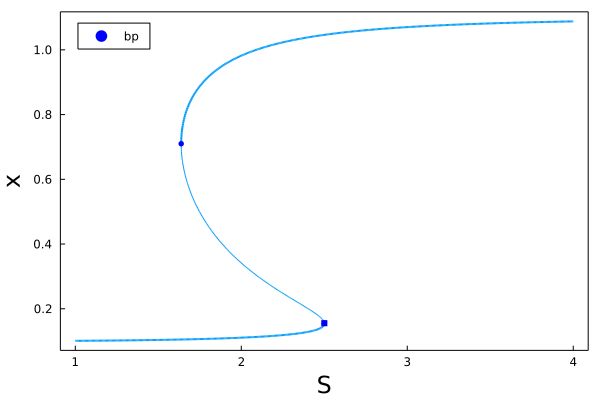

In [49]:
plot(br_1, plotfold=false, markersize=3, legend=:topleft)

In [450]:
bps_1 = select_bps(br_1,[1,2])
starts_1 = [1,bps_1[1].idx,bps_1[2].idx]
ends_1 = [bps_1[1].idx,bps_1[2].idx,length(br_1.branch)]
branches_1 = split_branch(br_1,starts_1,ends_1);

plot(); 
plot_branch!(branches_1[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_1[2];lw=lw,la=la,color=:red,linestyle=:dot)
plot_branch!(branches_1[3];lw=lw,la=la,color=:blue,linestyle=:solid)
plot!(xlimit=(S_span1[1],S_span1[2]))

plot_bp!(br_1, bps_1[1].idx, :yellow; ms=ms)
plot_bp!(br_1, bps_1[2].idx, :yellow; ms=ms);

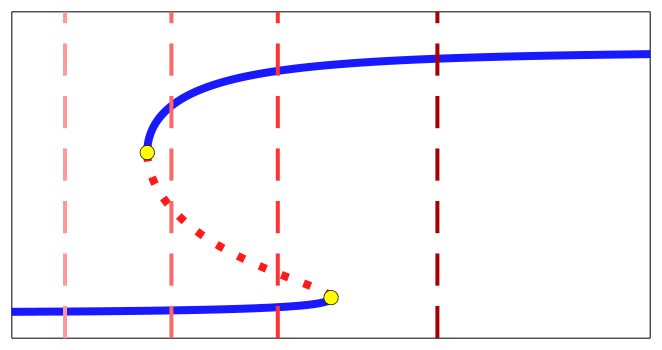

In [451]:
foreach(i -> plot_vertical_line!(S_vals1[i],vert_line_h,color=red_scale_4[i],lw=4,linestyle=:dash), 1:length(S_vals1))
bif_dia_1 = plot!(size=(662,350),ylimit=(0.0,vert_line_h),xticks=[],yticks=[])

In [452]:
save_figure(bif_dia_1, "Bifurcation_Diagrams/Additional_diagrams"; tag="bif1_", init="../Figures")

### Make bifurcation diagram 2

In [309]:
br_2 = continuation(bpProb2, PALC(tangent=Bordered()), opts_br2; plot=false, normC=norminf);

In [310]:
prob_ode = ODEProblem(genSigModel!,fill(par2.v0,4),(0.0,1000.0),p_vals2)

br_po_2_1 = continuation(br_2, 1, ContinuationPar(opts_po_cont2_1, dsmax=0.15, maxSteps=200), ShootingProblem(30, prob_ode, Rodas4P2(), jacobian=:autodiffDenseAnalytical, abstol=1e-11, reltol=1e-8, updateSectionEveryStep=1, parallel=true);
    δp=0.0001, verbosity=0, plot=false, callbackN=BK.cbMaxNorm(10), make_po_args(par2)...,);
br_po_2_2 = continuation(br_2, 4, ContinuationPar(opts_po_cont2_2, dsmax=0.15, maxSteps=200), ShootingProblem(30, prob_ode, Rodas4P2(), jacobian=:autodiffDenseAnalytical, abstol=1e-11, reltol=1e-8, updateSectionEveryStep=1, parallel=true);
    δp=0.0001, verbosity=0, plot=false, callbackN=BK.cbMaxNorm(10), make_po_args(par2)...,);

┌ Warning: Error in eigenvalues computation. It seems that an eigenvalue is missing, probably conj(λ) for some already computed eigenvalue λ. This makes the identification (but not the detection) of bifurcation points erroneous. You should increase the number of requested eigenvalues `nev`.
└ @ BifurcationKit /home/SLCU/torkel.loman/.julia/dev/BifurcationKit/src/Bifurcations.jl:110
┌ Warning: dt(2.220446049250313e-16) <= dtmin(2.220446049250313e-16) at t=1.0256227276343957. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/SLCU/torkel.loman/.julia/packages/SciMLBase/QzHjf/src/integrator_interface.jl:484
┌ Warning: dt(2.220446049250313e-16) <= dtmin(2.220446049250313e-16) at t=0.004916343011429848. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /home/SLCU/torkel.loman/.julia/packages/SciMLBase/QzHjf/src/integrator_interface.jl:484
┌ Warning: dt(2.22044604925

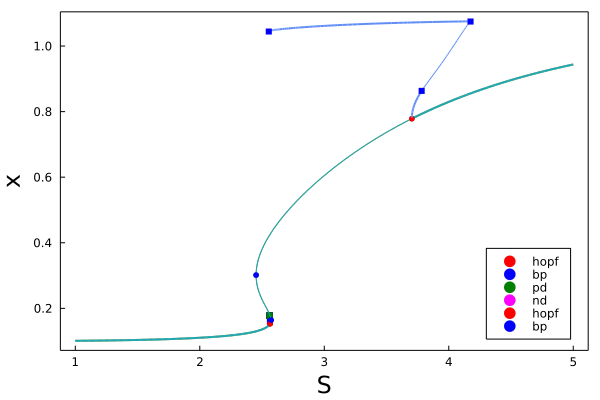

In [311]:
plot(br_2,br_po_2_1)
plot!(br_2,br_po_2_2,legend=:bottomright)

In [453]:
bps_2 = select_bps(br_2,[1,2,3,4])
starts_2 = [1,bps_2[1].idx,bps_2[4].idx]
ends_2 = [bps_2[1].idx,bps_2[4].idx,length(br_2.branch)]
branches_2 = split_branch(br_2,starts_2,ends_2);

plot(); 
plot_branch!(branches_2[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_2[2];lw=lw,la=la,color=:red,linestyle=:dot)
plot_branch!(branches_2[3];lw=lw,la=la,color=:blue,linestyle=:solid)
plot!(xlimit=(S_span2[1],S_span2[2]))

starts_po_2_1 = [1]
ends_po_2_1 = [length(br_po_2_1.branch)]
branches_po_2_1 = split_branch(br_po_2_1,starts_po_2_1,ends_po_2_1);

plot_po!(branches_po_2_1[1];lw=lw,la=la,color=:purple,linestyle=:dot)
plot!(xlimit=(S_span2[1],S_span2[2]))

bps_po_2_2 = select_bps(br_po_2_2,[1,2,3,4])
starts_po_2_2 = [1,81]
ends_po_2_2 = [81,length(br_po_2_2.branch)]
branches_po_2_2 = split_branch(br_po_2_2,starts_po_2_2,ends_po_2_2);

plot_po!(branches_po_2_2[1];lw=lw,la=la,color=:purple,linestyle=:dot)     # Stabiltiy of branch can be found out by sampling using "println(eigenvals(br_potrap, 4))" for various indexes along that branch.
plot_po!(branches_po_2_2[2];lw=lw,la=la,color=:purple,linestyle=:solid)
plot!(xlimit=(S_span2[1],S_span2[2]))

plot_bp!(br_2, bps_2[1].idx, :red; ms=ms)
plot_bp!(br_2, bps_2[2].idx, :yellow; ms=ms)
plot_bp!(br_2, bps_2[3].idx, :yellow; ms=ms)
plot_bp!(br_2, bps_2[4].idx, :red; ms=ms)
plot_bp_po!(br_po_2_2, 81, :yellow; ms=ms)

p_coord = branches_po_2_1[1][end].param
idx = bps_2[2].idx + findfirst(getfield.(br_2.branch,:param)[bps_2[2].idx:end] .< branches_po_2_1[1][end].param) - 1
p_val1 = br_2.branch[idx-1].param
x_val1 = br_2.branch[idx-1].x
p_val2 = br_2.branch[idx].param
x_val2 = br_2.branch[idx].x
x_coord = x_val1*(p_val2-p_coord)/(p_val2-p_val1) + x_val2*(p_coord-p_val1)/(p_val2-p_val1)
scatter!((p_coord,x_coord); color=:purple, ms=ms, label="")

p_coord = branches_po_2_2[2][end].param
idx = bps_2[2].idx + findfirst(getfield.(br_2.branch,:param)[bps_2[2].idx:end] .< branches_po_2_2[2][end].param) - 1
p_val1 = br_2.branch[idx-1].param
x_val1 = br_2.branch[idx-1].x
p_val2 = br_2.branch[idx].param
x_val2 = br_2.branch[idx].x
x_coord = x_val1*(p_val2-p_coord)/(p_val2-p_val1) + x_val2*(p_coord-p_val1)/(p_val2-p_val1)
bif_dia_2_tmp = scatter!((p_coord,x_coord); color=:purple, ms=ms, label="");

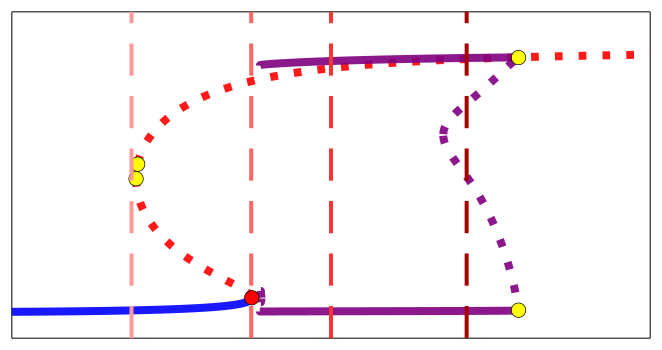

In [454]:
foreach(i -> plot_vertical_line!(S_vals2[i],vert_line_h,color=red_scale_4[i],lw=4,linestyle=:dash), 1:length(S_vals2))
bif_dia_2 = plot!(size=(662,350),ylimit=(0.0,vert_line_h),xticks=[],yticks=[])

In [314]:
save_figure(bif_dia_2, "Bifurcation_Diagrams/Additional_diagrams"; tag="bif2_", init="../Figures")

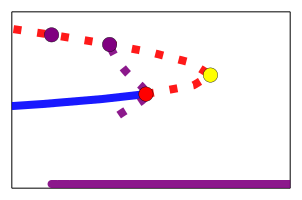

In [330]:
bif_dia_2_detail = plot!(bif_dia_2_tmp,size=(302,200),xlimit=(2.55,2.58),ylimit=(0.1,0.2))

In [331]:
save_figure(bif_dia_2_detail, "Bifurcation_Diagrams/Additional_diagrams"; tag="bif2_detail_", init="../Figures")

### Make bifurcation diagram 3

In [109]:
br_3 = continuation(bpProb3, PALC(tangent=Bordered()), opts_br3; plot=false, normC=norminf);

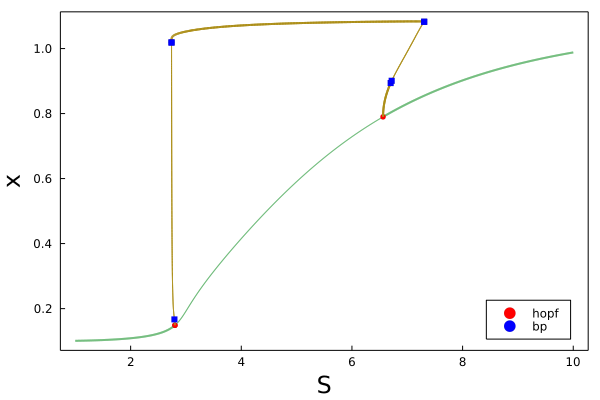

In [110]:
br_po_3 = continuation(br_3, 1, opts_po_cont3, PeriodicOrbitTrapProblem(M=200, jacobian=:Dense, updateSectionEveryStep=1); verbosity=0, callback=BK.cbMaxNorm(10), plot=false, make_po_args(par3)...).γ;
plot(br_3,br_po_3, legend=:bottomright)

In [319]:
bps_3 = select_bps(br_3,[1,2])
starts_3 = [1,bps_3[1].idx,bps_3[2].idx]
ends_3 = [bps_3[1].idx,bps_3[2].idx,length(br_3.branch)]
branches_3 = split_branch(br_3,starts_3,ends_3);

plot(); 
plot_branch!(branches_3[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_3[2];lw=lw,la=la,color=:red,linestyle=:dot)
plot_branch!(branches_3[3];lw=lw,la=la,color=:blue,linestyle=:solid)
plot!(xlimit=(S_span3[1],S_span3[2]))

bps_po_3 = select_bps(br_po_3,[1,2,3,4,5,6,7,8])
starts_po_3 = [161,391,769]
ends_po_3 = [391,465,length(br_po_3.branch)]
branches_po_3 = split_branch(br_po_3,starts_po_3,ends_po_3);

plot_po!(branches_po_3[1];lw=lw,la=la,color=:purple,linestyle=:solid)
plot_po!(branches_po_3[2];lw=lw,la=la,color=:purple,linestyle=:dot)
plot_po!(branches_po_3[3];lw=lw,la=la,color=:purple,linestyle=:dot)
plot!(xlimit=(S_span3[1],S_span3[2]))

plot_bp!(br_3, bps_3[1].idx, :red; ms=ms)
plot_bp!(br_3, bps_3[2].idx, :red; ms=ms)
plot_bp_po!(br_po_3, 161, :yellow; ms=ms)
plot_bp_po!(br_po_3, 391, :yellow; ms=ms);

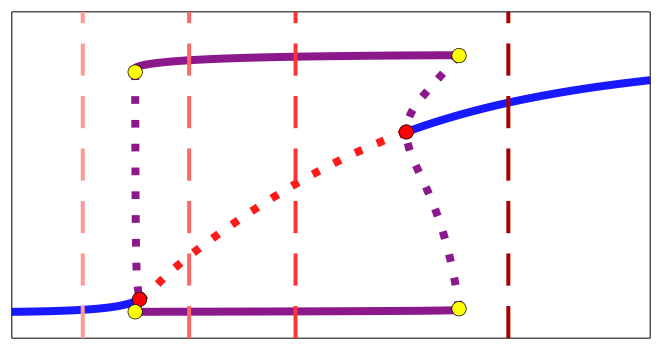

In [320]:
foreach(i -> plot_vertical_line!(S_vals3[i],vert_line_h,color=red_scale_4[i],lw=4,linestyle=:dash), 1:length(S_vals3))
bif_dia_3 = plot!(size=(662,350),ylimit=(0.0,vert_line_h),xticks=[],yticks=[])

In [321]:
save_figure(bif_dia_3, "Bifurcation_Diagrams/Additional_diagrams"; tag="bif3_", init="../Figures")

## Bifurcation diagram and behaviour map plot

### Preparations

In [111]:
ms = 22
lw = 22
la = 0.9;

In [112]:
p_vals1 = [1.0,0.2,2.0,0.1,3,0.1]; par1 = (S=p_vals1[1],D=p_vals1[2],τ=p_vals1[3],v0=p_vals1[4],n=p_vals1[5],η=p_vals1[6]);
p_vals2 = [1.0,1.0,2.0,0.1,3,0.1]; par2 = (S=p_vals2[1],D=p_vals2[2],τ=p_vals2[3],v0=p_vals2[4],n=p_vals2[5],η=p_vals2[6]);
p_vals3 = [1.0,5.0,2.0,0.1,3,0.1]; par3 = (S=p_vals3[1],D=p_vals3[2],τ=p_vals3[3],v0=p_vals3[4],n=p_vals3[5],η=p_vals3[6]);
p_vals4 = [1.0,25.,2.0,0.1,3,0.1]; par4 = (S=p_vals4[1],D=p_vals4[2],τ=p_vals4[3],v0=p_vals4[4],n=p_vals4[5],η=p_vals4[6]);
S_span = (1.0,100.0);

In [113]:
bpProb1 = BifurcationProblem(genSigModel, fill(par1.v0,4), par1, (@lens _.S); recordFromSolution = (x, p) -> x[1]);
bpProb2 = BifurcationProblem(genSigModel, fill(par2.v0,4), par2, (@lens _.S); recordFromSolution = (x, p) -> x[1]);
bpProb3 = BifurcationProblem(genSigModel, fill(par3.v0,4), par3, (@lens _.S); recordFromSolution = (x, p) -> x[1]);
bpProb4 = BifurcationProblem(genSigModel, fill(par4.v0,4), par4, (@lens _.S); recordFromSolution = (x, p) -> x[1]);

In [114]:
optn_po = NewtonPar(verbose=false, tol=1e-8,  maxIter=10);
opts_br =      ContinuationPar(pMin=S_span[1], pMax=S_span[2], dsmin=1e-4, ds= 0.005, dsmax=0.005, maxSteps=50000, detectBifurcation=3, nInversion=8, maxBisectionSteps=25, nev=4);
opts_po_cont2 = ContinuationPar(pMin=S_span[1], pMax=S_span[2], dsmin=1e-3, ds=0.05, dsmax=0.15,  maxSteps=500, newtonOptions=(@set optn_po.tol=1e-4), nev=4, tolStability=1.0, detectBifurcation=2, plotEveryStep=10, saveSolEveryStep=1);
opts_po_cont3 = ContinuationPar(pMin=S_span[1], pMax=S_span[2], dsmin=1e-6, ds=0.0005, dsmax=0.0015,  maxSteps=3000, newtonOptions=(@set optn_po.tol=1e-9), nev=4, tolStability=1e-4, detectBifurcation=2, plotEveryStep=10, saveSolEveryStep=1);
opts_po_cont4 = ContinuationPar(pMin=S_span[1], pMax=S_span[2], dsmin=1e-4, ds=-0.005, dsmax=0.05,  maxSteps=50000, newtonOptions=(@set optn_po.tol=1e-9), nev=4, tolStability=1e-2, detectBifurcation=2, plotEveryStep=10, saveSolEveryStep=1);

### Make diagrams

#### Bifurcation diagram 1

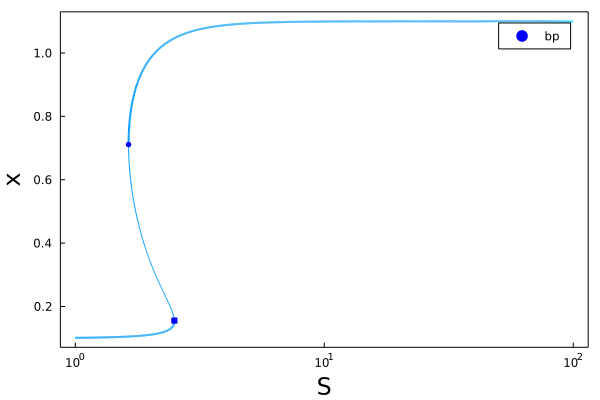

In [115]:
br_1 = continuation(bpProb1, PALC(tangent=Bordered()), opts_br; plot=false, normC=norminf);
plot(br_1,xaxis=:log10,xticks=[0.1,1.0,10.0,100.0])

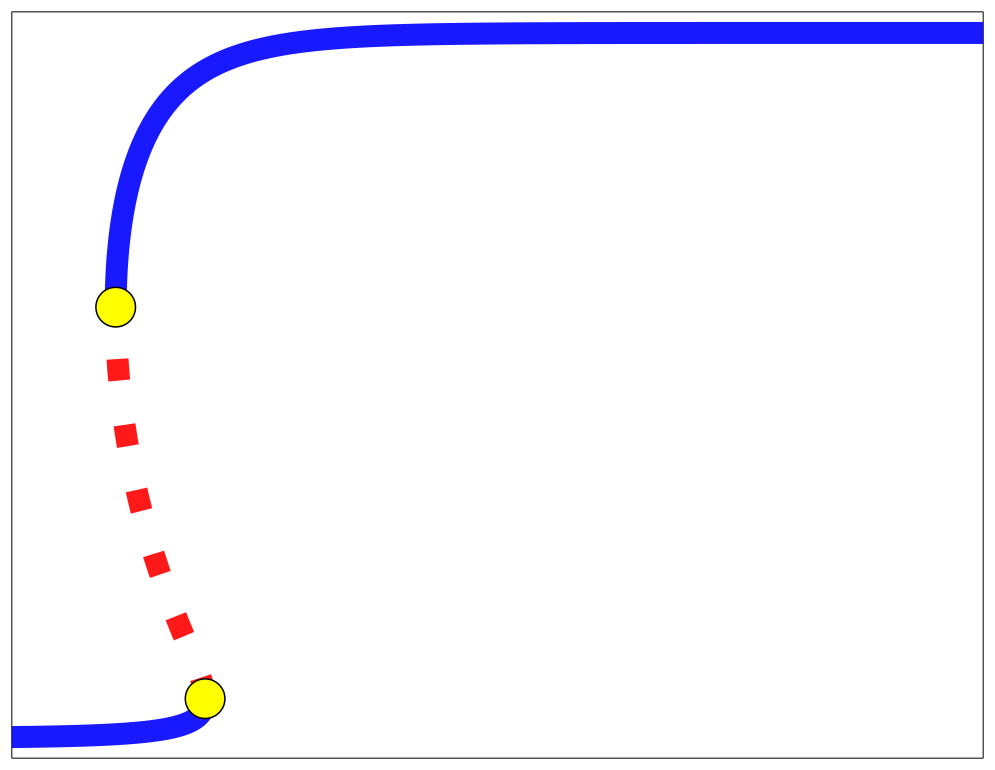

In [437]:
bps_1 = select_bps(br_1,[1,2])
starts_1 = [1,bps_1[1].idx,bps_1[2].idx]
ends_1 = [bps_1[1].idx,bps_1[2].idx,length(br_1.branch)]
branches_1 = split_branch(br_1,starts_1,ends_1);

plot(); 
plot_branch!(branches_1[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_1[2];lw=lw,la=la,color=:red,linestyle=:dot)
plot_branch!(branches_1[3];lw=lw,la=la,color=:blue,linestyle=:solid)
plot!(xlimit=(S_span[1],S_span[2]),xaxis=:log10,xticks=[0.1,1.0,10.0,100.0])

plot_bp!(br_1, bps_1[1].idx, :yellow; ms=ms)
bif_dia_bm_1 = plot_bp!(br_1, bps_1[2].idx, :yellow; ms=ms,size=(995,770),xticks=[],yticks=[])

In [438]:
save_figure(bif_dia_bm_1, "Behaviour_Map_Bifurcation_Diagrams/Additional_diagrams"; tag="bif1_", init="../Figures")

#### Bifurcation diagram 2

 56.727050 seconds (105.35 M allocations: 6.267 GiB, 3.07% gc time)


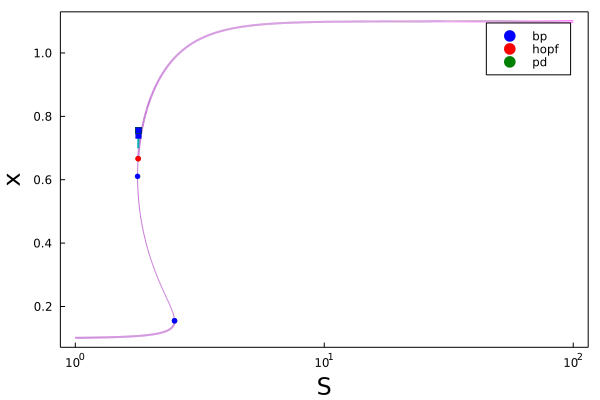

In [339]:
br_2 = continuation(bpProb2, PALC(tangent=Bordered()), opts_br; plot=false, normC=norminf);
@time br_po_2 = continuation(br_2, 3, opts_po_cont2, ShootingProblem(30, ODEProblem(genSigModel!,fill(par2.v0,4),(0.0,1000.0),p_vals2), Rodas4P2(), jacobian=:autodiffDenseAnalytical, abstol=1e-11, reltol=1e-8, updateSectionEveryStep=1, parallel=true);
    δp=0.001, verbosity=0, plot=false, callbackN=BK.cbMaxNorm(10), make_po_args(par2)...,);
plot(br_2,br_po_2,xaxis=:log10,xticks=[0.1,1.0,10.0,100.0])

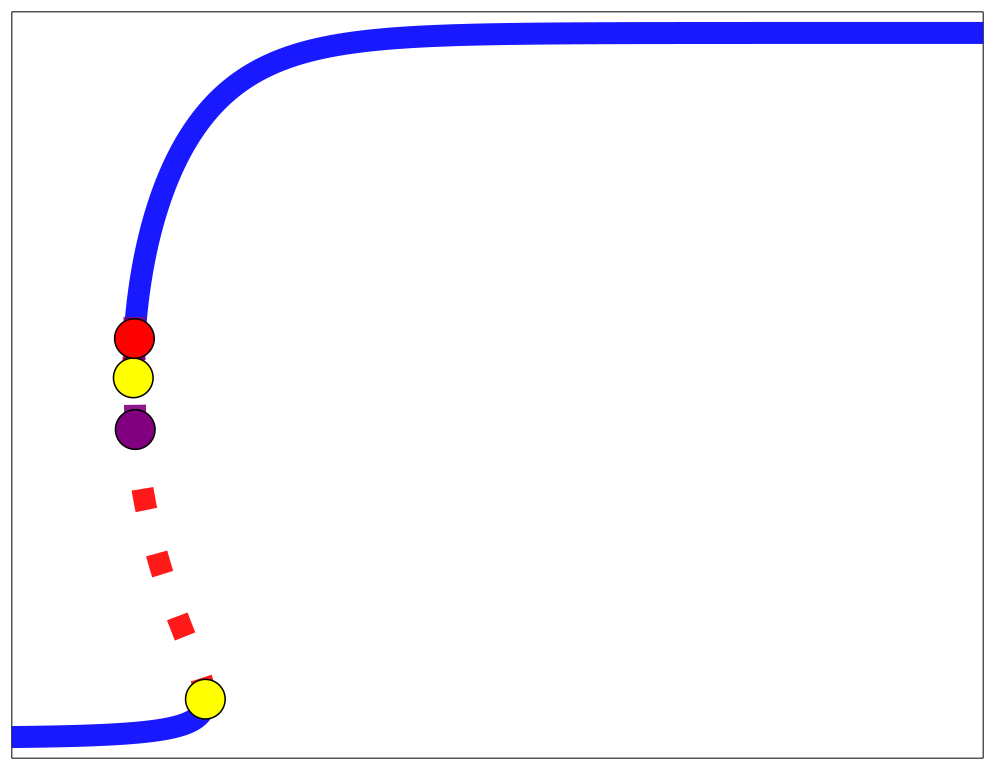

In [471]:
bps_2 = select_bps(br_2,[1,2,3])
starts_2 = [1,bps_2[1].idx,bps_2[3].idx]
ends_2 = [bps_2[1].idx,bps_2[3].idx,length(br_2.branch)]
branches_2 = split_branch(br_2,starts_2,ends_2);

plot(); 
plot_branch!(branches_2[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_2[2];lw=lw,la=la,color=:red,linestyle=:dot)
plot_branch!(branches_2[3];lw=lw,la=la,color=:blue,linestyle=:solid)
plot!(xlimit=(S_span[1],S_span[2]),xaxis=:log10)

starts_po_2 = [1]
ends_po_2 = [length(br_po_2.branch)]
branches_po_2 = split_branch(br_po_2,starts_po_2,ends_po_2);

#plot_po!(branches_po_2[1];lw=lw,la=la,color=:purple,linestyle=:dot)
plot!([bps_2[3].param;getfield.(branches_po_2[1],:param)],[bps_2[3].x[1];getfield.(branches_po_2[1],:max)],lw=lw,la=la,color=:purple,linestyle=:dot,label="")
plot!([bps_2[3].param;getfield.(branches_po_2[1],:param)],[bps_2[3].x[1];getfield.(branches_po_2[1],:min)],lw=lw,la=la,color=:purple,linestyle=:dot,label="")
plot!(xlimit=(S_span[1],S_span[2]))

plot_bp!(br_2, bps_2[1].idx, :yellow; ms=ms)
plot_bp!(br_2, bps_2[2].idx, :yellow; ms=ms)
plot_bp!(br_2, bps_2[3].idx, :red; ms=ms)

p_coord = branches_po_2[1][end].param
idx = findfirst(getfield.(branches_2[2],:param) .< branches_po_2[1][end].param)
p_val1 = branches_2[2][idx-1].param
x_val1 = branches_2[2][idx-1].x
p_val2 = branches_2[2][idx].param
x_val2 = branches_2[2][idx].x
x_coord = x_val1*(p_val2-p_coord)/(p_val2-p_val1) + x_val2*(p_coord-p_val1)/(p_val2-p_val1)
bif_dia_bm_2 = scatter!((p_coord,x_coord); color=:purple, ms=ms, label="",size=(995,770),xticks=[],yticks=[])

In [463]:
save_figure(bif_dia_bm_2, "Behaviour_Map_Bifurcation_Diagrams/Additional_diagrams"; tag="bif2_", init="../Figures")

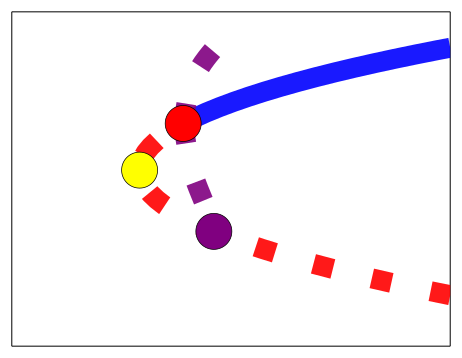

In [492]:
scale_factor = 1.1;

bps_2 = select_bps(br_2,[1,2,3])
starts_2 = [1,bps_2[1].idx,bps_2[3].idx]
ends_2 = [bps_2[1].idx,bps_2[3].idx,length(br_2.branch)]
branches_2 = split_branch(br_2,starts_2,ends_2);

plot(); 
plot_branch!(branches_2[1];lw=lw/scale_factor,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_2[2];lw=lw/scale_factor,la=la,color=:red,linestyle=:dot)
plot_branch!(branches_2[3];lw=lw/scale_factor,la=la,color=:blue,linestyle=:solid)
plot!(xlimit=(S_span[1],S_span[2]),xaxis=:log10)

starts_po_2 = [1]
ends_po_2 = [length(br_po_2.branch)]
branches_po_2 = split_branch(br_po_2,starts_po_2,ends_po_2);

#plot_po!(branches_po_2[1];lw=lw,la=la,color=:purple,linestyle=:dot)
plot!([bps_2[3].param;getfield.(branches_po_2[1],:param)],[bps_2[3].x[1];getfield.(branches_po_2[1],:max)],lw=lw/scale_factor,la=la,color=:purple,linestyle=:dot,label="")
plot!([bps_2[3].param;getfield.(branches_po_2[1],:param)],[bps_2[3].x[1];getfield.(branches_po_2[1],:min)],lw=lw/scale_factor,la=la,color=:purple,linestyle=:dot,label="")
plot!(xlimit=(S_span[1],S_span[2]))

plot_bp!(br_2, bps_2[1].idx, :yellow; ms=ms/scale_factor)
plot_bp!(br_2, bps_2[2].idx, :yellow; ms=ms/scale_factor)
plot_bp!(br_2, bps_2[3].idx, :red; ms=ms/scale_factor)

p_coord = branches_po_2[1][end].param
idx = findfirst(getfield.(branches_2[2],:param) .< branches_po_2[1][end].param)
p_val1 = branches_2[2][idx-1].param
x_val1 = branches_2[2][idx-1].x
p_val2 = branches_2[2][idx].param
x_val2 = branches_2[2][idx].x
x_coord = x_val1*(p_val2-p_coord)/(p_val2-p_val1) + x_val2*(p_coord-p_val1)/(p_val2-p_val1)
bif_dia_bm_2_detailed = scatter!((p_coord,x_coord); color=:purple, ms=ms/scale_factor, label="",xlimit=(1.75,1.85),ylimit=(0.4,0.8),size=(995/2.15,770/2.15),xticks=[],yticks=[])

In [493]:
save_figure(plot!(bif_dia_bm_2_detailed,xticks=[],yticks=[]), "Behaviour_Map_Bifurcation_Diagrams/Additional_diagrams"; tag="bif2_detailed_", init="../Figures")

#### Bifurcation diagram 3

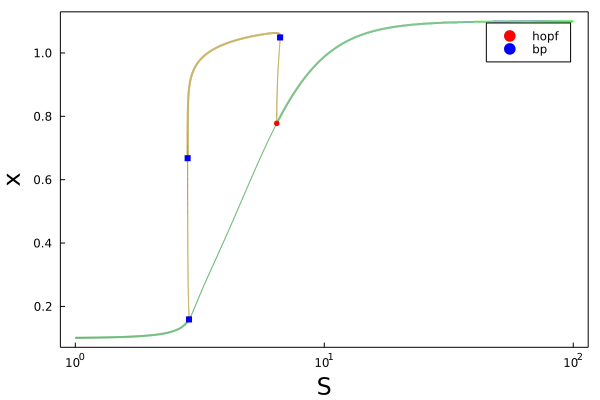

In [366]:
br_3 = continuation(bpProb3, PALC(tangent=Bordered()), opts_br; plot=false, normC=norminf);
br_po_3 = continuation(br_3, 2, opts_po_cont3, ShootingProblem(30, ODEProblem(genSigModel!,fill(par3.v0,4),(0.0,1000.0),p_vals3), Rodas4P2(), jacobian=:autodiffDenseAnalytical, abstol=1e-11, reltol=1e-8, updateSectionEveryStep=1, parallel=true);
    δp=0.0001, verbosity=0, plot=false, callbackN=BK.cbMaxNorm(10), make_po_args(par3)...,);
plot(br_3,br_po_3,xaxis=:log10,xticks=[0.1,1.0,10.0,100.0])

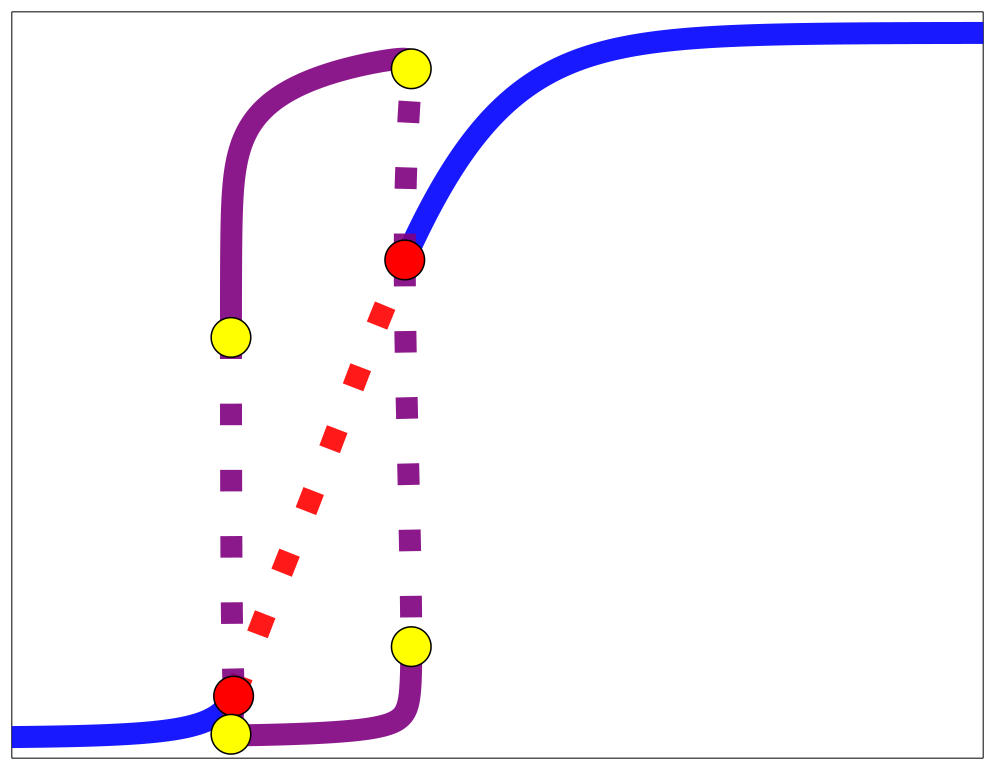

In [443]:
bps_3 = select_bps(br_3,[1,2,3])
starts_3 = [1,bps_3[1].idx,bps_3[2].idx]
ends_3 = [bps_3[1].idx,bps_3[2].idx,length(br_3.branch)]
branches_3 = split_branch(br_3,starts_3,ends_3);

plot(); 
plot_branch!(branches_3[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_3[2];lw=lw,la=la,color=:red,linestyle=:dot)
plot_branch!(branches_3[3];lw=lw,la=la,color=:blue,linestyle=:solid)

bps_po_3 = select_bps(br_po_3,[1,2,3,4])
starts_po_3 = [1,253,2526]
ends_po_3 = [253,2526,2930]
branches_po_3 = split_branch(br_po_3,starts_po_3,ends_po_3);

plot_po!(branches_po_3[1];lw=lw,la=la,color=:purple,linestyle=:dot)
plot_po!(branches_po_3[2];lw=lw,la=la,color=:purple,linestyle=:solid)
plot_po!(branches_po_3[3];lw=lw,la=la,color=:purple,linestyle=:dot)

plot_bp!(br_3, bps_3[1].idx, :red; ms=ms)
plot_bp!(br_3, bps_3[2].idx, :red; ms=ms)
plot_bp_po!(br_po_3, 253, :yellow; ms=ms)
plot_bp_po!(br_po_3, 2526, :yellow; ms=ms)
bif_dia_bm_3 = plot!(xlimit=(S_span[1],S_span[2]),xaxis=:log10,size=(995,770),xticks=[],yticks=[])

In [444]:
save_figure(bif_dia_bm_3, "Behaviour_Map_Bifurcation_Diagrams/Additional_diagrams"; tag="bif3_", init="../Figures")

#### Bifurcation diagram 4

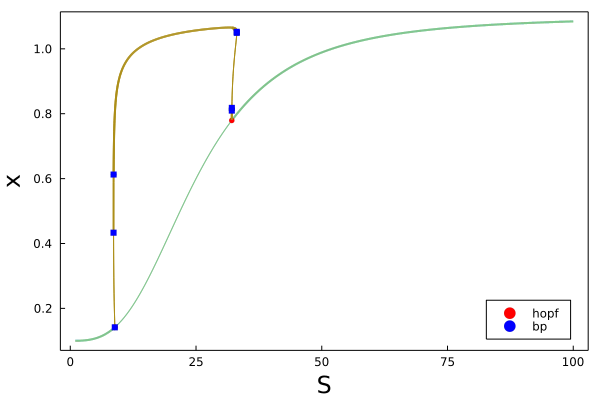

In [346]:
br_4 = continuation(bpProb4, PALC(tangent=Bordered()), opts_br; plot=false, normC=norminf);
br_po_4 = continuation(br_4, 1, opts_po_cont4, PeriodicOrbitTrapProblem(M=200, jacobian=:Dense, updateSectionEveryStep=1); verbosity=0, callback=BK.cbMaxNorm(10), plot=false, make_po_args(par4)...).γ;
plot(br_4,br_po_4, legend=:bottomright)

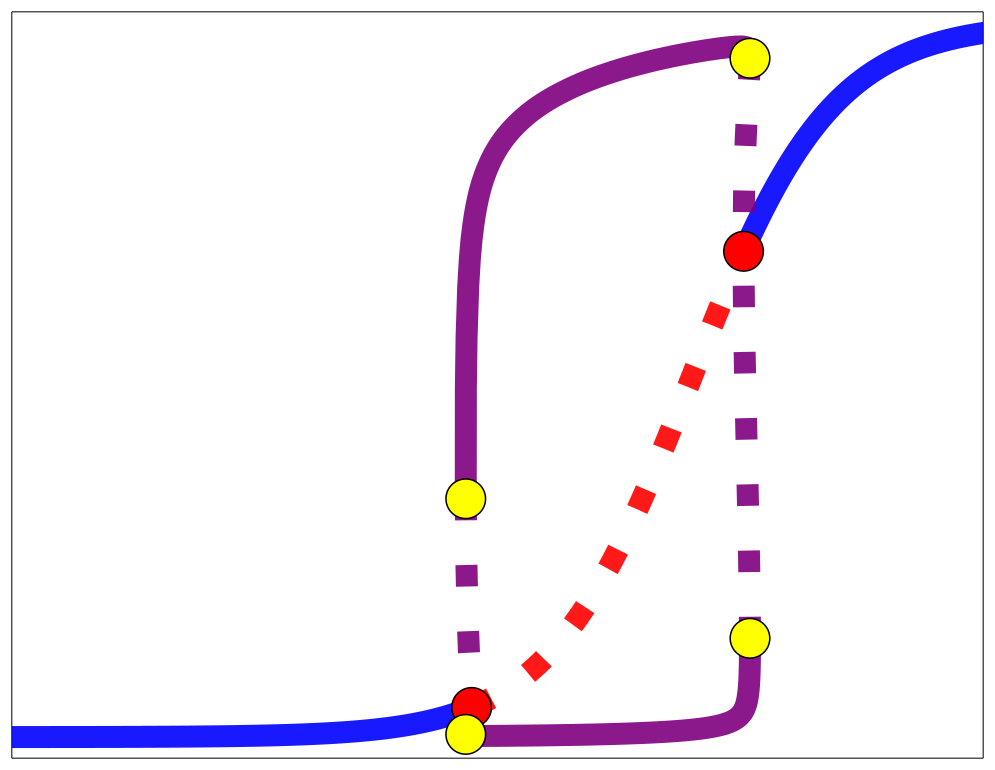

In [445]:
bps_4 = select_bps(br_4,[1,2])
starts_4 = [1,bps_4[1].idx,bps_4[2].idx]
ends_4 = [bps_4[1].idx,bps_4[2].idx,length(br_4.branch)]
branches_4 = split_branch(br_4,starts_4,ends_4);

plot(); 
plot_branch!(branches_4[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_4[2];lw=lw,la=la,color=:red,linestyle=:dot)
plot_branch!(branches_4[3];lw=lw,la=la,color=:blue,linestyle=:solid)

bps_po_4 = select_bps(br_po_4,[1,2,3,4,5,6,7,8])
starts_po_4 = [376,413,764]
ends_po_4 = [395,764,770]
branches_po_4 = split_branch(br_po_4,starts_po_4,ends_po_4);

plot_po!(branches_po_4[1];lw=lw,la=la,color=:purple,linestyle=:dot)
plot_po!(branches_po_4[2];lw=lw,la=la,color=:purple,linestyle=:solid)
plot_po!(branches_po_4[3];lw=lw,la=la,color=:purple,linestyle=:dot)

plot_bp!(br_4, bps_4[1].idx, :red; ms=ms)
plot_bp!(br_4, bps_4[2].idx, :red; ms=ms)
plot_bp_po!(br_po_4, 376, :yellow; ms=ms)
plot_bp_po!(br_po_4, 764, :yellow; ms=ms)
bif_dia_bm_4 = plot!(xlimit=(S_span[1],S_span[2]),xaxis=:log10,size=(995,770),xticks=[],yticks=[])

In [446]:
save_figure(bif_dia_bm_4, "Behaviour_Map_Bifurcation_Diagrams/Additional_diagrams"; tag="bif4_", init="../Figures")

## Continuation of bifurcation points

### Prepare options

In [158]:
D_vals = [0.5,1.0,2.5,10.0]
p_vals1 = [1.0,D_vals[1],2.0,0.1,3,0.1]; par1 = (S=p_vals1[1],D=p_vals1[2],τ=p_vals1[3],v0=p_vals1[4],n=p_vals1[5],η=p_vals1[6]);
p_vals2 = [1.0,D_vals[2],2.0,0.1,3,0.1]; par2 = (S=p_vals2[1],D=p_vals2[2],τ=p_vals2[3],v0=p_vals2[4],n=p_vals2[5],η=p_vals2[6]);
p_vals3 = [1.0,D_vals[3],2.0,0.1,3,0.1]; par3 = (S=p_vals3[1],D=p_vals3[2],τ=p_vals3[3],v0=p_vals3[4],n=p_vals3[5],η=p_vals3[6]);
p_vals4 = [1.0,D_vals[4],2.0,0.1,3,0.1]; par4 = (S=p_vals4[1],D=p_vals4[2],τ=p_vals4[3],v0=p_vals4[4],n=p_vals4[5],η=p_vals4[6]);
S_span = (1.0,100.0);

In [159]:
opts_br = ContinuationPar(pMin=0.1, pMax=100.0, dsmin=1e-4, ds= 0.005, dsmax=0.005, maxSteps=50000, detectBifurcation=3, nInversion=8, maxBisectionSteps=25, nev=4);
bpProb1 = BifurcationProblem(genSigModel, fill(par1.v0,4), par1, (@lens _.S); recordFromSolution = (x, p) -> x[1]);
bpProb2 = BifurcationProblem(genSigModel, fill(par2.v0,4), par2, (@lens _.S); recordFromSolution = (x, p) -> x[1]);
bpProb3 = BifurcationProblem(genSigModel, fill(par3.v0,4), par3, (@lens _.S); recordFromSolution = (x, p) -> x[1]);
bpProb4 = BifurcationProblem(genSigModel, fill(par4.v0,4), par4, (@lens _.S); recordFromSolution = (x, p) -> x[1]);

### Make diagrams

In [160]:
br_1 = continuation(bpProb1, PALC(tangent=Bordered()), opts_br; plot=false, normC=norminf);
br_2 = continuation(bpProb2, PALC(tangent=Bordered()), opts_br; plot=false, normC=norminf);
br_3 = continuation(bpProb3, PALC(tangent=Bordered()), opts_br; plot=false, normC=norminf);
br_4 = continuation(bpProb4, PALC(tangent=Bordered()), opts_br; plot=false, normC=norminf);
plot(plot(br_1),plot(br_2),plot(br_3),plot(br_4),layout=(1,4),size=(1600,350),xaxis=:log10,yguide="",xguide="");

In [112]:
ms = 9
lw = 8
la = 0.9;

In [113]:
bps_1 = select_bps(br_1,[1,2])
starts_1 = [1,bps_1[1].idx,bps_1[2].idx]
ends_1 = [bps_1[1].idx,bps_1[2].idx,length(br_1.branch)]
branches_1 = split_branch(br_1,starts_1,ends_1);

plot(); 
plot_branch!(branches_1[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_1[2];lw=lw,la=la,color=:red,linestyle=:dot)
plot_branch!(branches_1[3];lw=lw,la=la,color=:blue,linestyle=:solid)
plot!(xlimit=(1.0,100.0))

plot_bp!(br_1, bps_1[1].idx, :yellow; ms=ms)
br_plot_1 = plot_bp!(br_1, bps_1[2].idx, :yellow; ms=ms,xaxis=:log10);

In [114]:
bps_2 = select_bps(br_2,[1,2,3])
starts_2 = [1,bps_2[1].idx,bps_2[3].idx]
ends_2 = [bps_2[1].idx,bps_2[3].idx,length(br_2.branch)]
branches_2 = split_branch(br_2,starts_2,ends_2);

plot(); 
plot_branch!(branches_2[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_2[2];lw=lw,la=la,color=:red,linestyle=:dot)
plot_branch!(branches_2[3];lw=lw,la=la,color=:blue,linestyle=:solid)
plot!(xlimit=(1.0,100.0))

plot_bp!(br_2, bps_2[1].idx, :yellow; ms=ms)
plot_bp!(br_2, bps_2[2].idx, :yellow; ms=ms,xaxis=:log10)
br_plot_2 = plot_bp!(br_2, bps_2[3].idx, :red; ms=ms,xaxis=:log10);

In [115]:
bps_3 = select_bps(br_3,[1,2,3])
starts_3 = [1,bps_3[1].idx,bps_3[3].idx]
ends_3 = [bps_3[1].idx,bps_3[3].idx,length(br_3.branch)]
branches_3 = split_branch(br_3,starts_3,ends_3);

plot(); 
plot_branch!(branches_3[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_3[2];lw=lw,la=la,color=:red,linestyle=:dot)
plot_branch!(branches_3[3];lw=lw,la=la,color=:blue,linestyle=:solid)
plot!(xlimit=(1.0,100.0))

plot_bp!(br_3, bps_3[1].idx, :yellow; ms=ms)
plot_bp!(br_3, bps_3[2].idx, :yellow; ms=ms,xaxis=:log10)
br_plot_3 = plot_bp!(br_3, bps_3[3].idx, :red; ms=ms,xaxis=:log10);

In [116]:
bps_4 = select_bps(br_4,[1,2])
starts_4 = [1,bps_4[1].idx,bps_4[2].idx]
ends_4 = [bps_4[1].idx,bps_4[2].idx,length(br_4.branch)]
branches_4 = split_branch(br_4,starts_4,ends_4);

plot(); 
plot_branch!(branches_4[1];lw=lw,la=la,color=:blue,linestyle=:solid)
plot_branch!(branches_4[2];lw=lw,la=la,color=:red,linestyle=:dot)
plot_branch!(branches_4[3];lw=lw,la=la,color=:blue,linestyle=:solid)
plot!(xlimit=(1.0,100.0))

plot_bp!(br_4, bps_4[1].idx, :red; ms=ms)
br_plot_4 = plot_bp!(br_4, bps_4[2].idx, :red; ms=ms,xaxis=:log10);

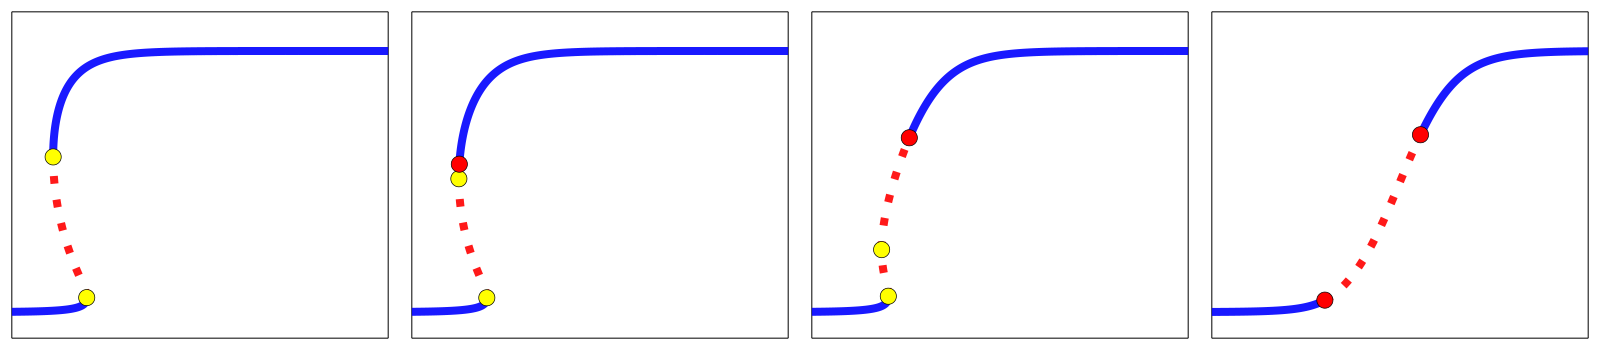

In [231]:
bifurcation_diagram_plots = plot(br_plot_1,br_plot_2,br_plot_3,br_plot_4,layout=(1,4),size=(1600,350),xaxis=:log10,yguide="",xguide="",xticks=[],yticks=[],ylimit=(0.0,1.25))

### Track bifurcation points

In [211]:
function cont_br_bp(br,bp;maxSteps=3000)
    continuation(br, bp, (@lens _.D),
        ContinuationPar(opts_br, pMin = 0.1, pMax = 100.0, ds = -0.001, dsmax=0.05, maxSteps = maxSteps);
        normC = norminf,
        detectCodim2Bifurcation = 2,
        recordFromSolution = (u,p; kw...) -> (x = u.u[1] ),
        updateMinAugEveryStep = 1,
        bothside=true,)
end;

In [212]:
par_extra = (S=1.0,D=0.2,τ=2.0,v0=0.1,n=3.0,η=0.1)
br_extra = continuation(BifurcationProblem(genSigModel, fill(par_extra.v0,4), par_extra, (@lens _.S); recordFromSolution = (x, p) -> x[1]), PALC(tangent=Bordered()), opts_br; plot=false, normC=norminf);

In [221]:
br_1_bp_1 = cont_br_bp(br_extra,1;maxSteps=51);
br_1_bp_2 = cont_br_bp(br_extra,2;maxSteps=44);
br_4_bp_1 = cont_br_bp(br_4,1;maxSteps=3000);
br_4_bp_2 = cont_br_bp(br_4,2;maxSteps=3000);

┌ Error: Newton failed to fully locate bifurcation point using bisection parameters!
└ @ BifurcationKit /home/SLCU/torkel.loman/.julia/dev/BifurcationKit/src/events/EventDetection.jl:107


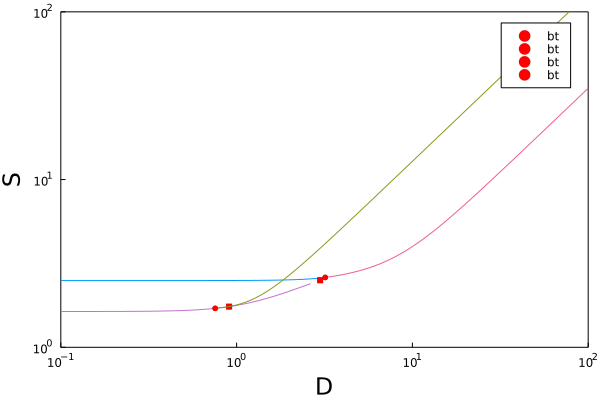

In [222]:
plot(br_1_bp_1, vars=(:D, :S))
plot!(br_1_bp_2, vars=(:D, :S))
plot!(br_4_bp_1, vars=(:D, :S))
plot!(br_4_bp_2, vars=(:D, :S))
plot!(xlimit=(0.1,100.0),ylimit=(1.0,100.0),xaxis=:log10,yaxis=:log10)

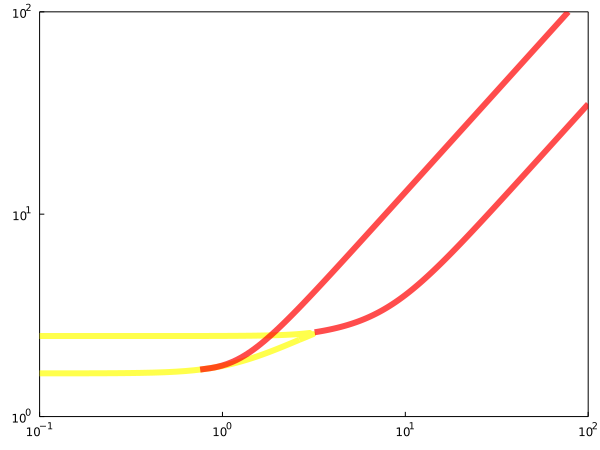

In [230]:
lw = 6; la = 0.7;
plot([br_1_bp_2.branch[1].D;getfield.(br_1_bp_1.branch,:D)],[br_1_bp_2.branch[1].S;getfield.(br_1_bp_1.branch,:2)],label="",lw=lw,la=la,color=:yellow)
plot!(getfield.(br_1_bp_2.branch,:D),getfield.(br_1_bp_2.branch,:2),label="",lw=lw,la=la,color=:yellow)
plot!(getfield.(br_4_bp_1.branch,:D),getfield.(br_4_bp_1.branch,:2),label="",lw=lw,la=la,color=:red)
plot!(getfield.(br_4_bp_2.branch,:D),getfield.(br_4_bp_2.branch,:2),label="",lw=lw,la=la,color=:red)
bifurcation_point_lines_plot = plot!(xlimit=(0.1,100.0),ylimit=(1.0,100.0),xaxis=:log10,yaxis=:log10,size=(600,450))

### Plot behaviour space

In [123]:
target_folder = "BehaviourMap"
behaviour_path_3I = "../"

S_grid = 10 .^(range(-1,stop=2,length=300))
D_grid = 10 .^(range(-1,stop=2,length=300))
τ_grid = [0.1,0.15,0.20,0.30,0.50,0.75,1.0,1.5,2.0,3.0,5.0,7.50,10.0,15.0,20.0,30.0,50.0,75.0,100.0]
v0_grid = [0.01,0.02,0.03,0.05,0.075,0.1,0.15,0.20]
n_grid = [2.0,3.0,4.0]
η_grid = [0.001,0.002,0.005,0.01,0.02,0.05,0.1]

dataset = DataSet(target_folder,S_grid,D_grid,τ_grid,v0_grid,n_grid,η_grid);

In [124]:
params = [2.0,0.1,3,0.1];
bg = BehaviourGrid(params,dataset);
plot_behaviour_gbifurcation_point_lines_plotrid(bg,start_s_slice=100,idx_axis=false,xguide="D",yguide="S");
foreach(D -> plot!([D,D],[1,200.0],label="",color=:black,lw=2), map(D_val -> findfirst(D_grid .> D_val), D_vals))
behaviour_space_1 = plot!(xlimit=(1,300),ylimit=(1,201));

In [125]:
params = [2.0,0.1,3,0.001];
bg = BehaviourGrid(params,dataset);
plot_behaviour_grid(bg,start_s_slice=100,idx_axis=false,xguide="D",yguide="S");
foreach(D -> plot!([D,D],[1,200.0],label="",color=:black,lw=2), map(D_val -> findfirst(D_grid .> D_val), D_vals))
behaviour_space_2 = plot!(xlimit=(1,300),ylimit=(1,201));

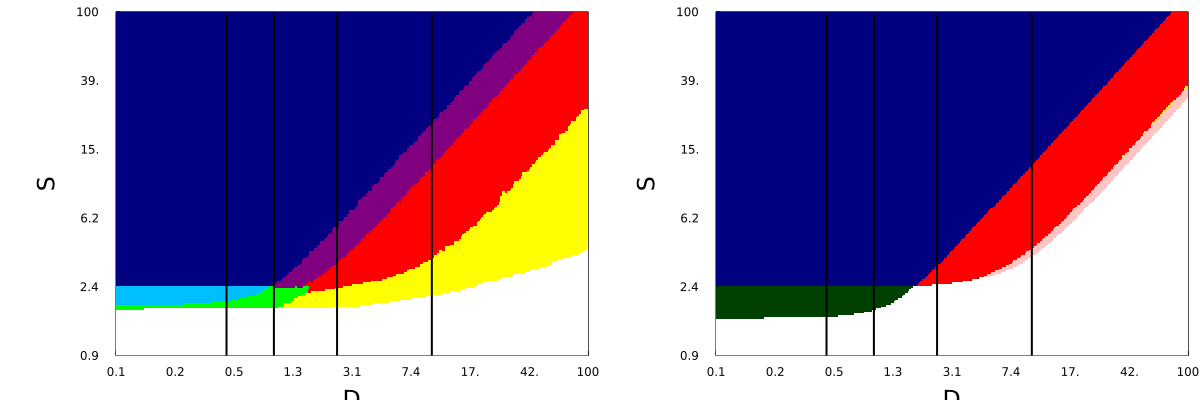

In [126]:
behaviour_space_plots = plot(behaviour_space_1,behaviour_space_2,size=(1200,400))

### Save figure

In [232]:
save_figure(bifurcation_diagram_plots,"Continuation_of_Bifurcation_Points"; tag="bifurcation_diagrams_", init="../Figures")
save_figure(bifurcation_point_lines_plot,"Continuation_of_Bifurcation_Points"; tag="bifurcation_lines_", init="../Figures")
save_figure(behaviour_space_plots,"Continuation_of_Bifurcation_Points"; tag="behaviour_maps_", init="../Figures");